This project was based on a Kaggle competition with the following scenario:

<i>Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.</i>

In this way, the project consists of solving the problem proposed above.

# 0. IMPORTS

In [126]:
import pandas as pd
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats

from boruta                import BorutaPy
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from matplotlib.gridspec   import GridSpec
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from IPython.display       import Image
from IPython.core.display  import HTML

## 0.1. Helper Functions

In [127]:
def cramer_v(x, y): 
    cm = pd.crosstab(x, y)
    cm = cm.to_numpy()
    chi2 = stats.chi2_contingency(cm, correction=False)[0]
    r, k = cm.shape
    n = cm.sum()
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)   

    V = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

    return(V)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

In [128]:
display( HTML( '<style>.container { width:100% !important; }</style>') )

## 0.2. Loading Data


Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince**[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since**[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [129]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1. DATA DESCRIPTION

In [130]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [131]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [132]:
print ('Number of Rows: {}'.format(df1.shape[0]))
print ('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [133]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [134]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [135]:
# competition_distance - assumed that NA's are very far competitors
max_value = df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_value*2 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1) 


# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1) 

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'July', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6. Change Types

In [136]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

## 1.7. Descriptive statistics

In [137]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5810.044888,10715.012901,20.0,710.0,2330.0,6910.0,151720.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [138]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [139]:
# Central Tentency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,151720.0,151700.0,5810.044888,2330.0,10715.007635,7.593832,90.447876
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\gabriellima\Anaconda3\envs\rossmann_project\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customers', ylabel='Density'>

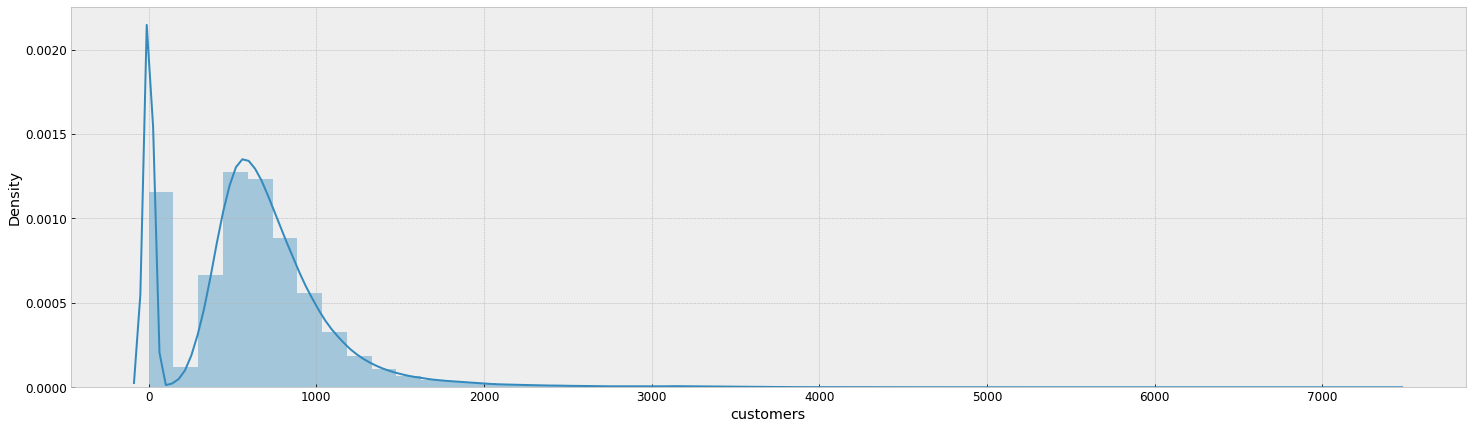

In [140]:
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 7]
plt.rcParams['font.size'] = 12

sns.distplot(df1['customers'])

### 1.7.2. Categorical Attributes

In [141]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

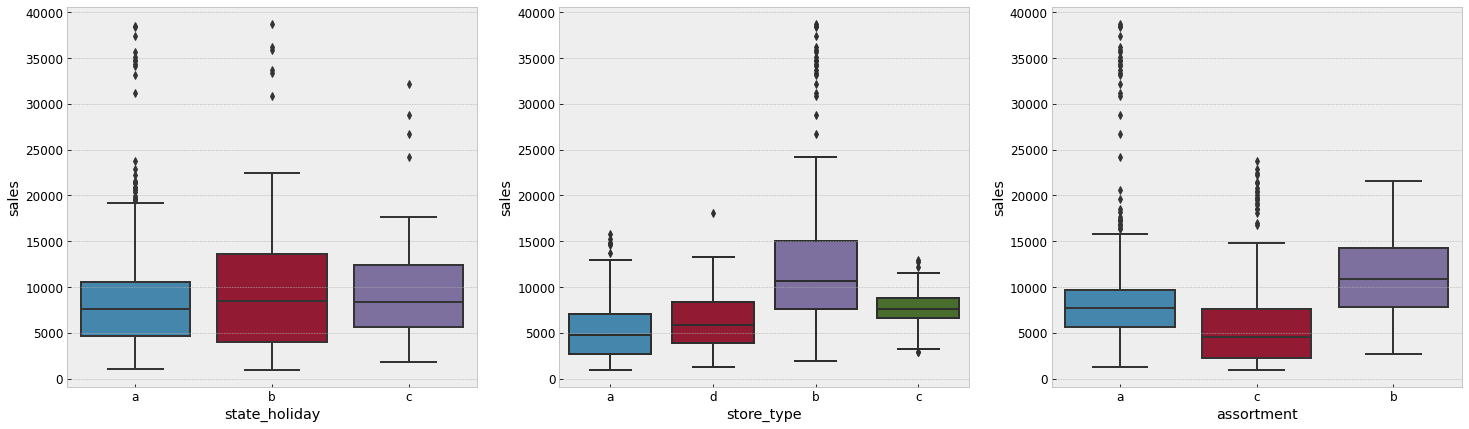

In [142]:
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 7]
plt.rcParams['font.size'] = 12

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2. FEATURE ENGINEERING

In [143]:
df2 = df1.copy()

## 2.1. Mind Map Hypotheses

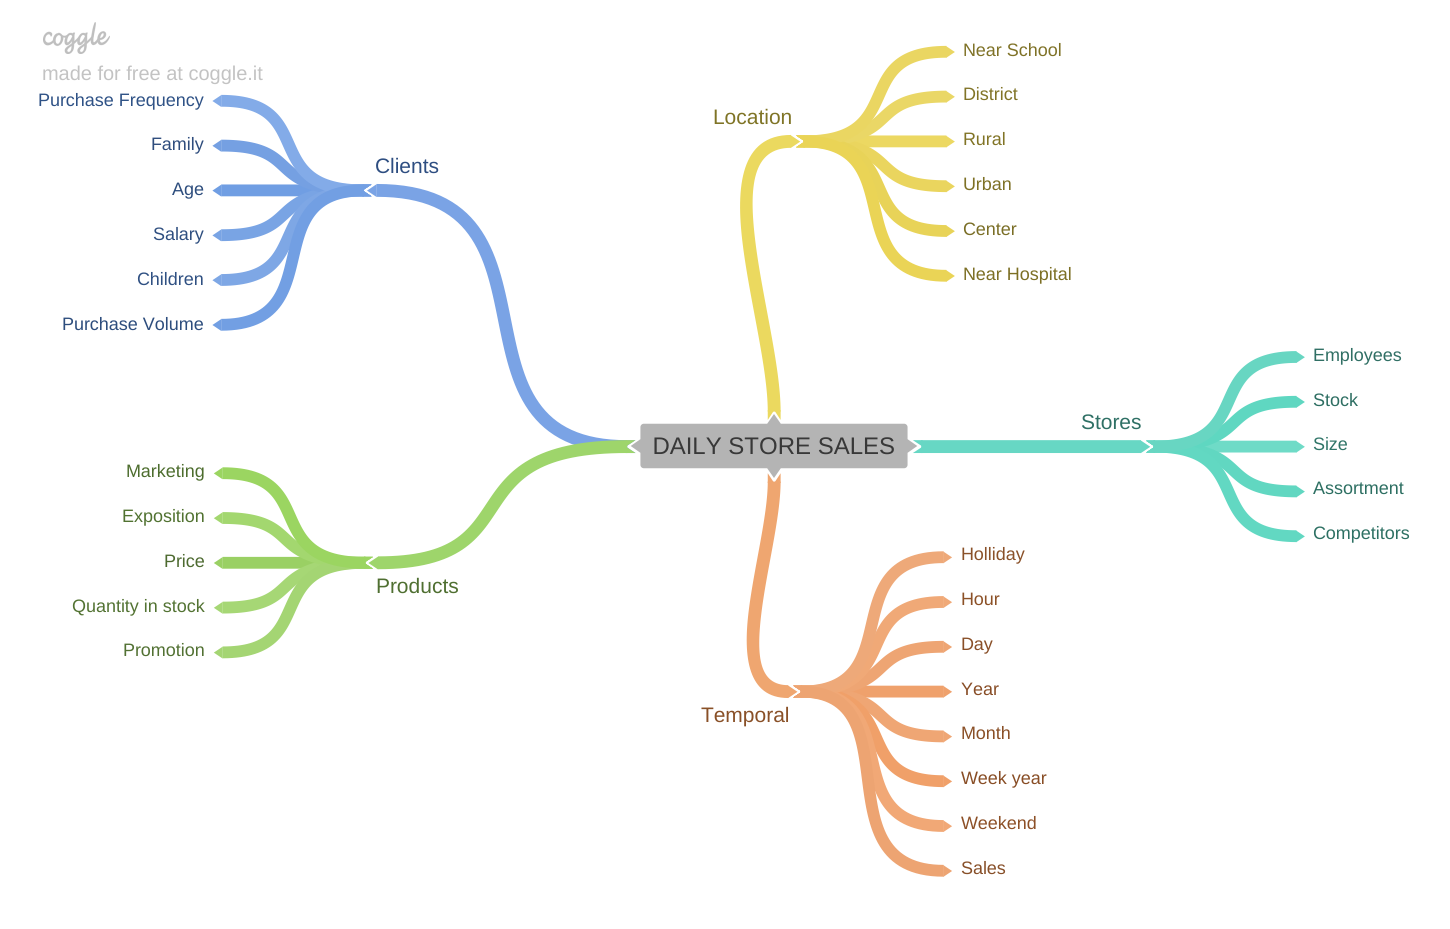

In [144]:
Image('img/MindMapHypotheses.png')

## 2.2. Creation of Hypotheses

This is not a cause and effect relationship, it's just an attempt to try to find correlations.

### 2.2.1. Store Hypotheses

**1.** Stores with more employees should sell more.

**2.** Stores with more stock should sell more.

**3.** Bigger stores should sell more.

**4.** Stores with bigger assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 2.2.2. Product Hypotheses

**1.** Stores that invest more in marketing should sell more.

**2.** Stores with greater exposure in the windows should sell more.

**3.** Stores with lower prices on products should sell more.

**4.** Stores with bigger discounts should sell more.

**5.** Stores with active promotions for longer should sell more.

**6.** Stores with longer promotions should sell more.

**7.** stores with more consecutive promotions should sell more.

### 2.2.3. Temporal Hypotheses

**1.** Stores open at Christmas should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekend.

**6.** Stores should sell more during the School Holidays.

## 2.3. Final Hypotheses

**1.** Stores with bigger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with longer promotions should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open at Christmas should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekend.

**12.** Stores should sell more during the School Holidays.

## 2.3. Feature Engineering

In [145]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month']  = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo2_time_week']  = ((df2['date'] - df2['promo2_since'])/7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday - a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

C:\Users\gabriellima\AppData\Local\Temp\ipykernel_46696\1324226423.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [146]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. VARIABLE FILTERING

In [147]:
df3 = df2.copy()

## 3.1. Row Filtering

In [148]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selecting

In [149]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4. EXPLORATION DATA ANALYSIS

In [150]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

C:\Users\gabriellima\Anaconda3\envs\rossmann_project\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


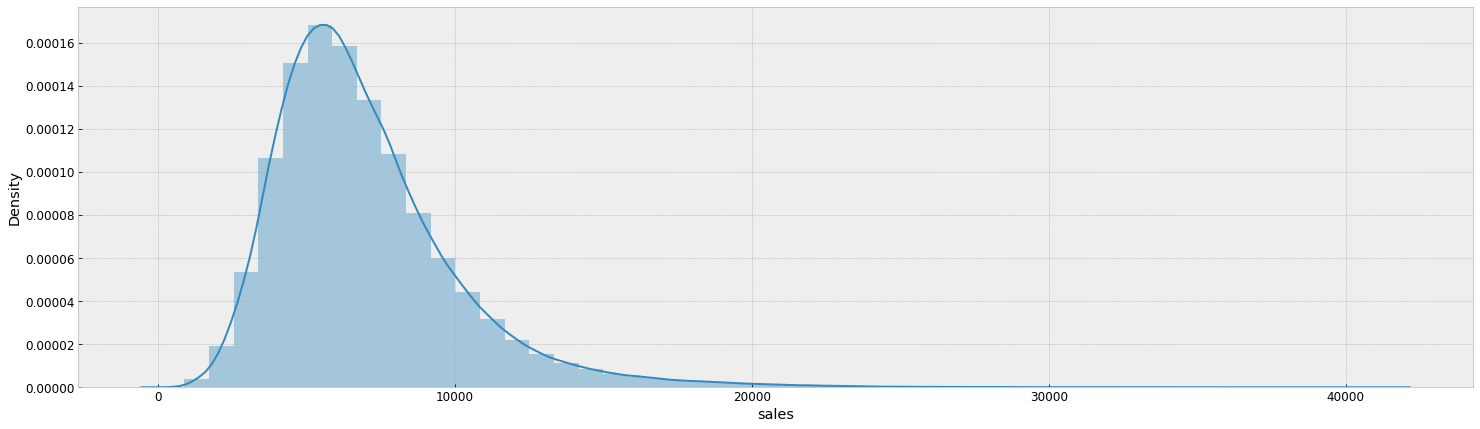

In [151]:
sns.distplot(df4['sales']);

### 4.1.2. Numerical Variable

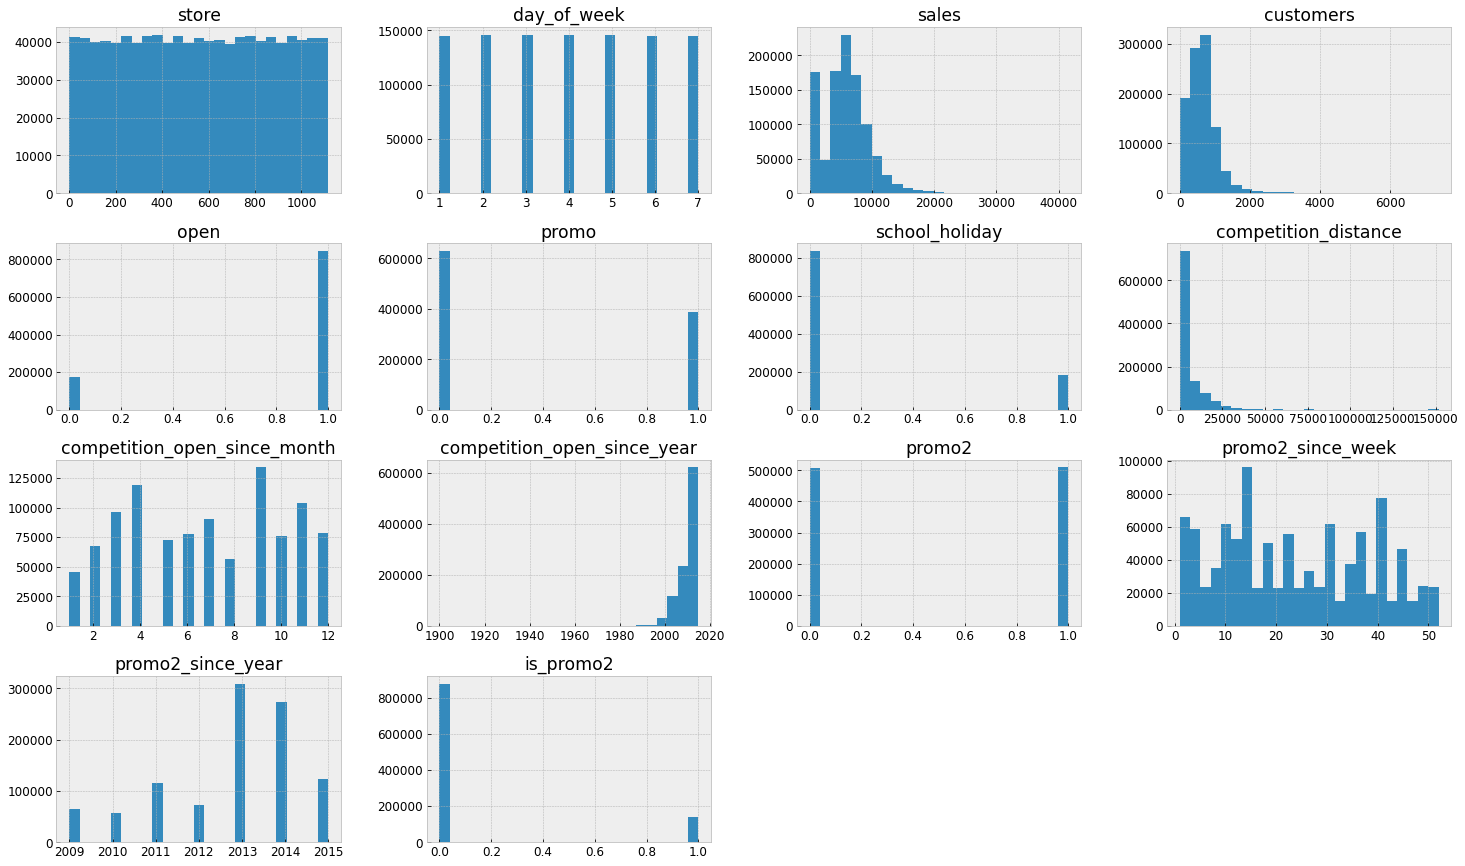

In [152]:
plt.rcParams['figure.figsize'] = [25, 15]
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

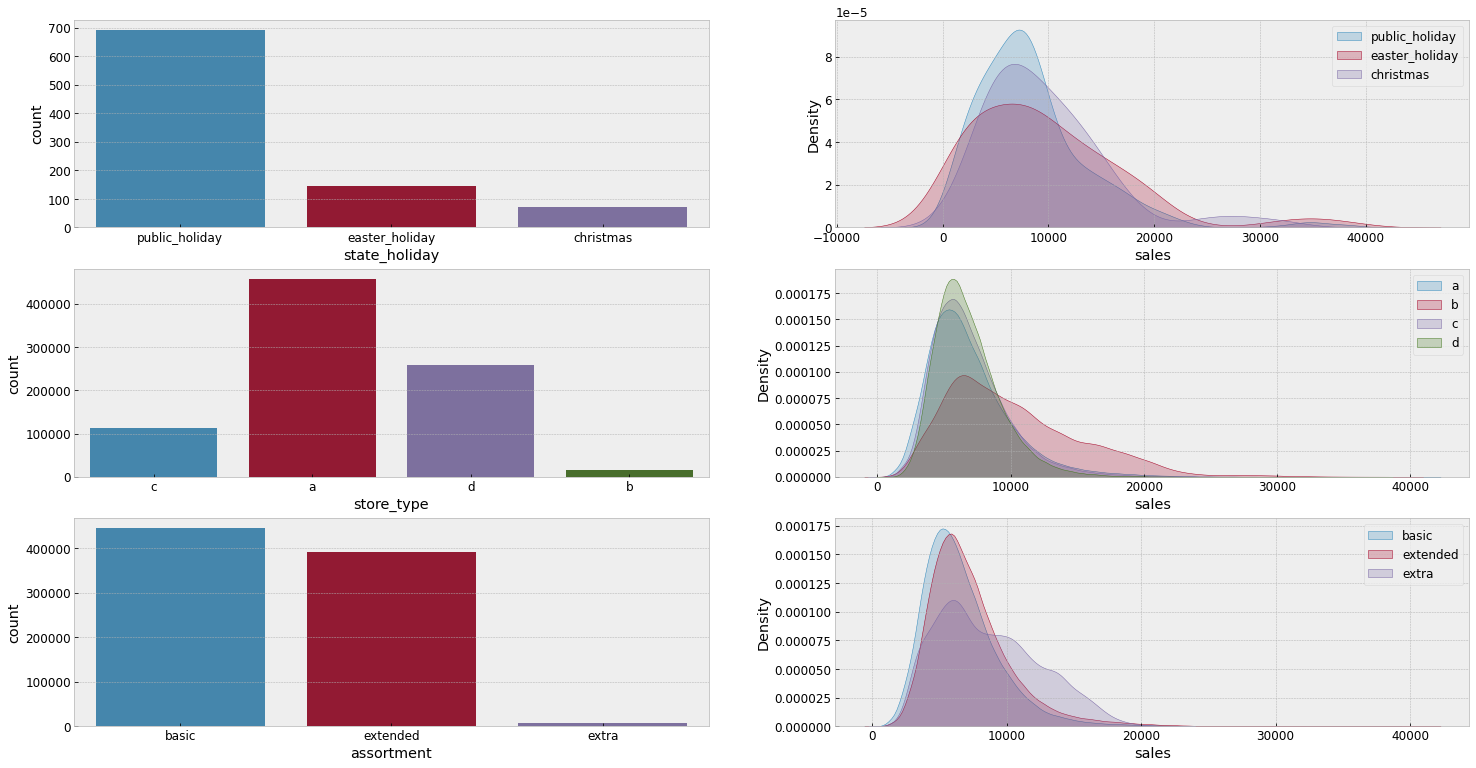

In [153]:
plt.rcParams['figure.figsize'] = [25, 13]

# state_holiday
plt.subplot(3, 2, 1)
sns.countplot(x=df4[df4['state_holiday'] != 'regular_day']['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True, label='public_holiday');
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True, label='easter_holiday');
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade=True, label='christmas');
plt.legend()

#store_type
plt.subplot(3, 2, 3)
sns.countplot(x=df4['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade=True, label='a');
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade=True, label='b');
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade=True, label='c');
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade=True, label='d');
plt.legend();

#assortment
plt.subplot(3, 2, 5)
sns.countplot(x=df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade=True, label='basic');
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade=True, label='extended');
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade=True, label='extra');
plt.legend();

## 4.2. Bivariate Analysis

### **H1.** Stores with bigger assortment should sell more.
**Rejected**. Store with **bigger assortment** sell **less**. And it can be relevant to the model.

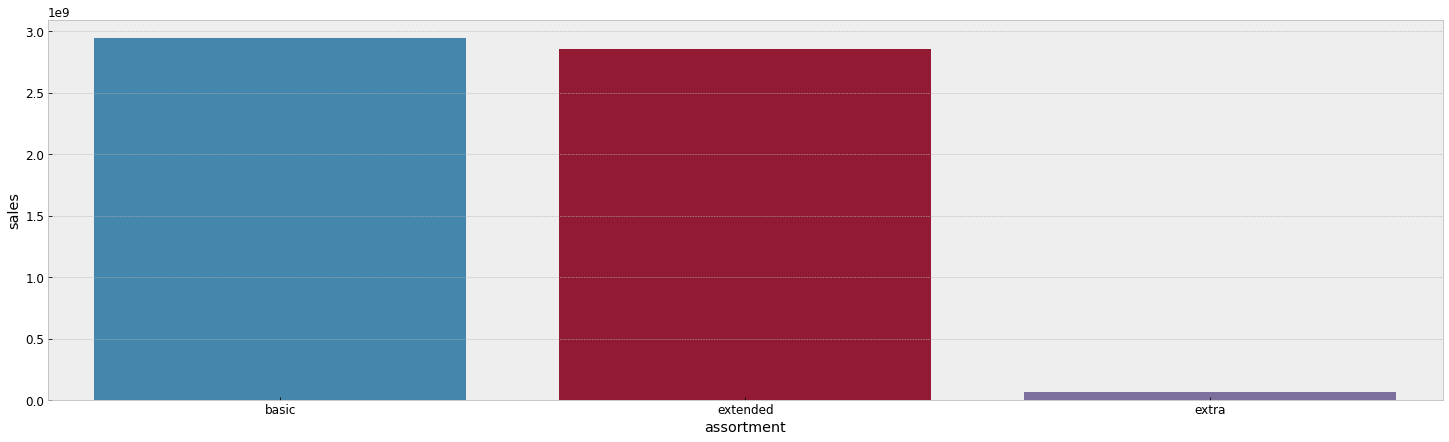

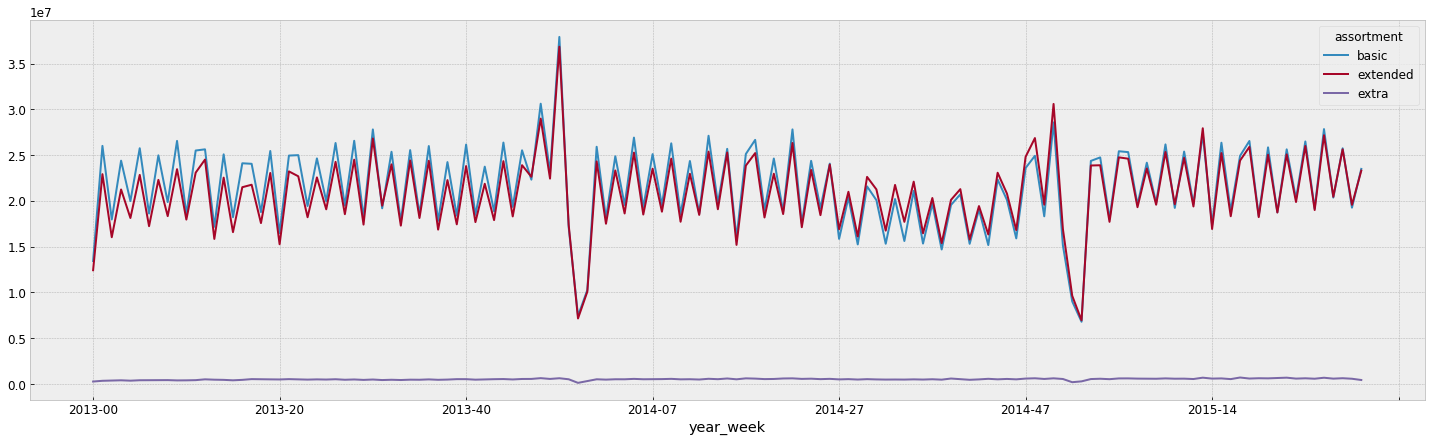

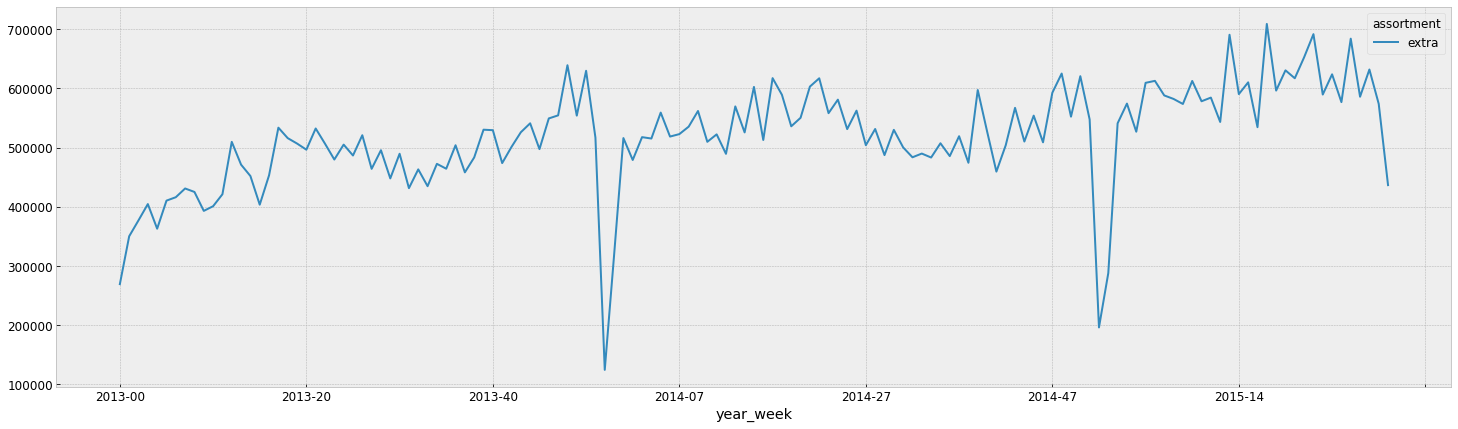

In [154]:
# assuming that extra > extended > basic

plt.rcParams['figure.figsize'] = [25, 7]
aux1 = pd.pivot_table(df4, values='sales', index=['assortment'], aggfunc=np.sum).reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

pd.pivot_table(df4, values='sales', index='year_week', columns='assortment', aggfunc=np.sum).reset_index().plot(x='year_week');

pd.pivot_table(df4[df4['assortment']=='extra'], values='sales', index='year_week', columns='assortment', aggfunc=np.sum).reset_index().plot(x='year_week');

### **H2.** Stores with closer competitors should sell less.
**Rejected**. Store with **closer competitors** sell **more**. And it can be relevant to the model.

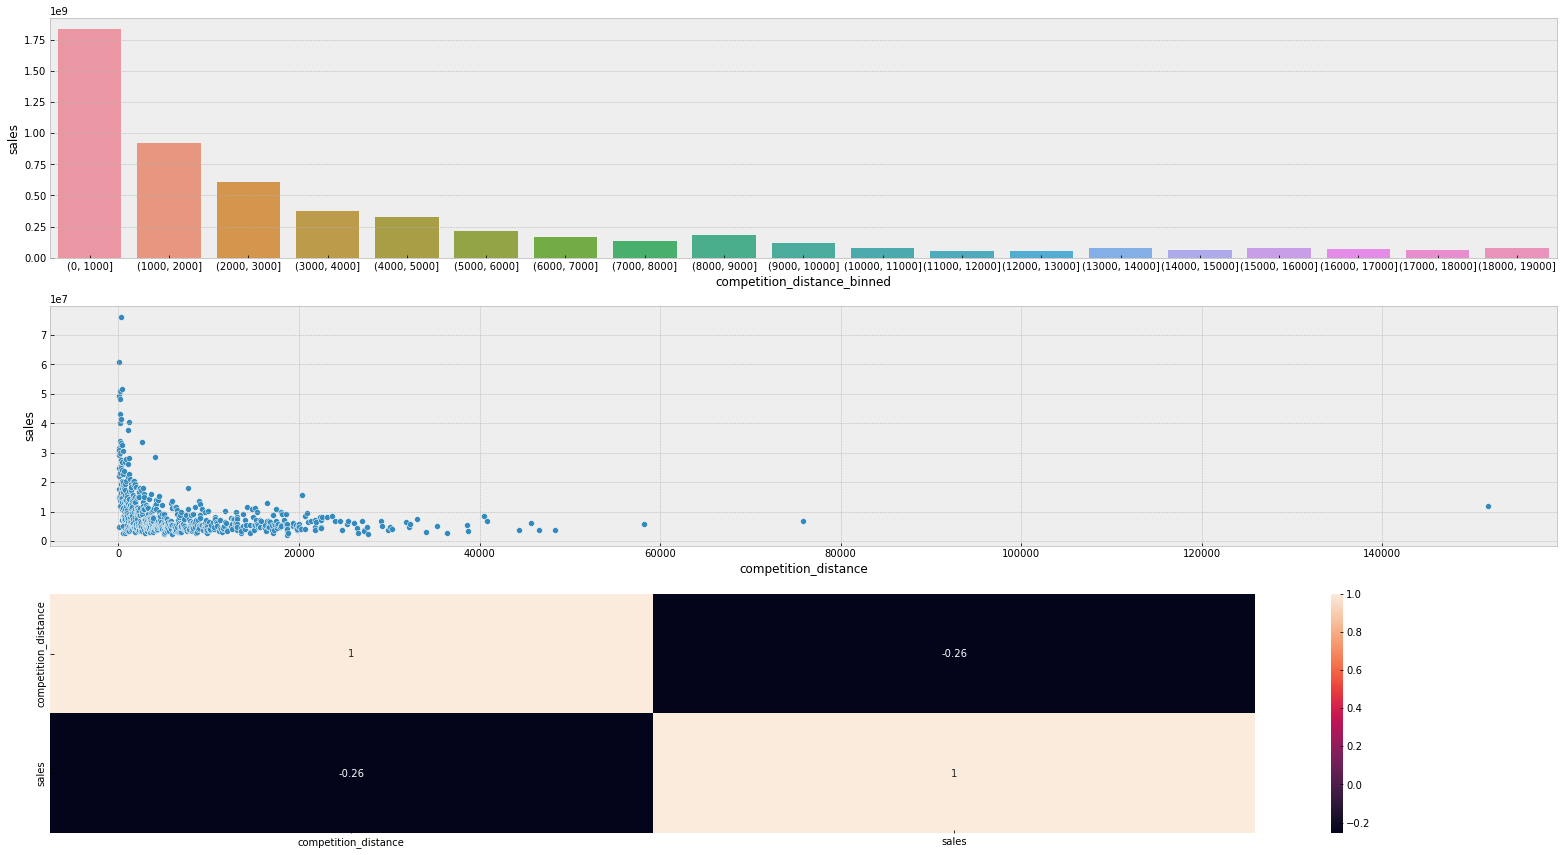

In [155]:
aux1 = pd.pivot_table(df4, values='sales', index='competition_distance', aggfunc='sum').reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = pd.pivot_table(aux1, values='sales', index='competition_distance_binned', aggfunc='sum').reset_index()

plt.rcParams['figure.figsize'] = [27, 15]
plt.rcParams['font.size'] = 10

plt.subplot(3, 1, 1)
sns.barplot(data=aux2, x='competition_distance_binned', y='sales');

plt.subplot(3, 1, 2)
sns.scatterplot(data=aux1, x='competition_distance', y='sales');

plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Stores with longer competitors should sell more.
**Rejected**. The more **recent** the competitor, the **higher the sales**. And it can be relevant to the model.

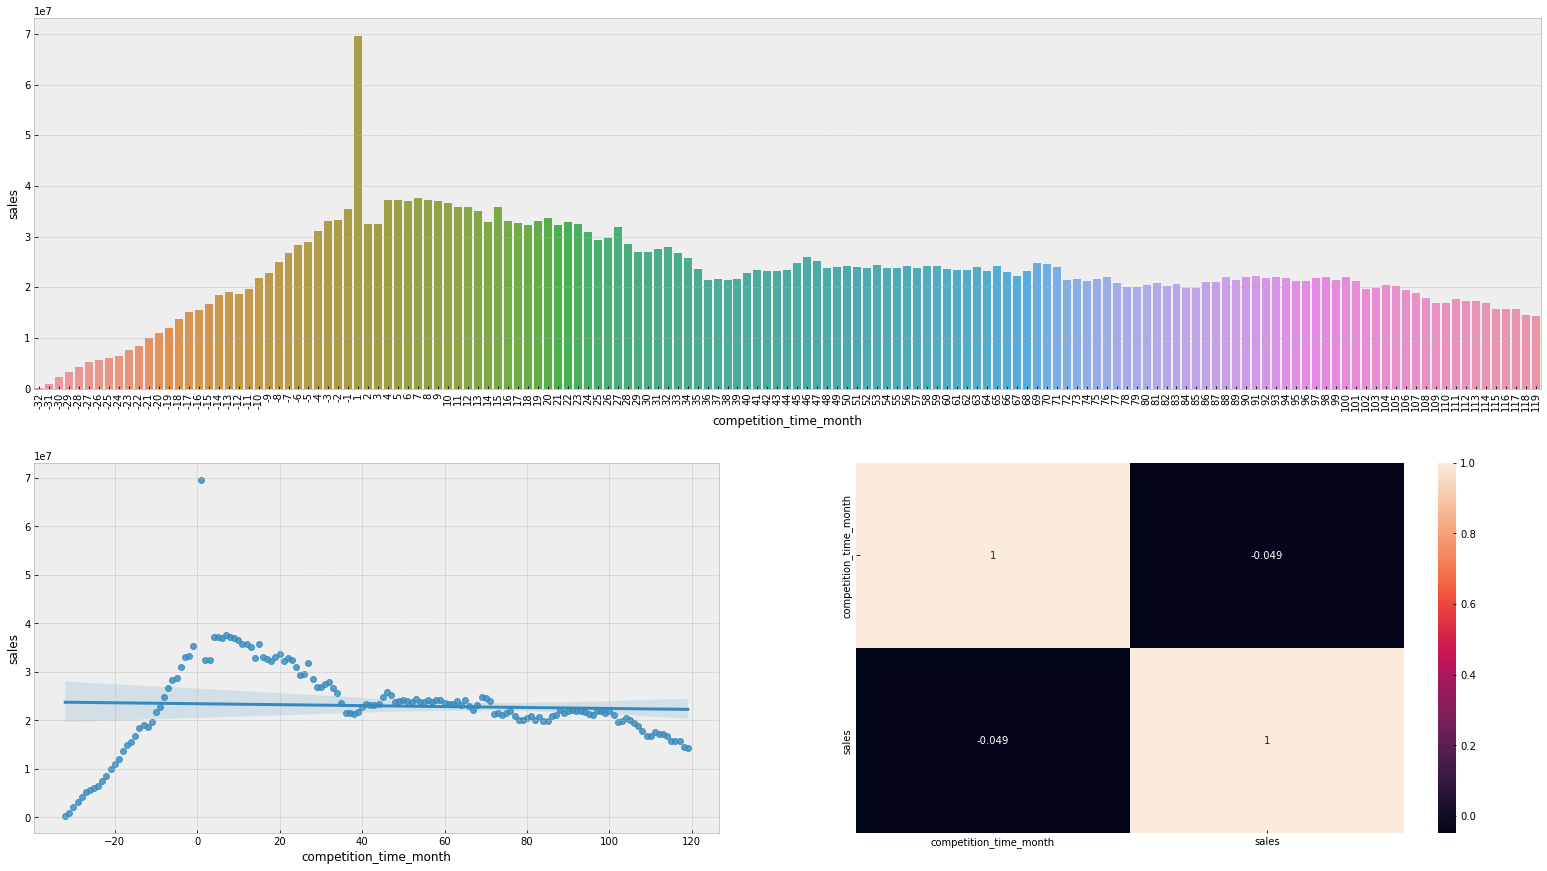

In [156]:
aux1 = pd.pivot_table(df4, values='sales', index='competition_time_month', aggfunc='sum').reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.rcParams['figure.figsize'] = [27, 15]

plt.subplot2grid((2,2), (0,0) , colspan=2)
sns.barplot(data=aux2, x='competition_time_month', y='sales');
plt.xticks(rotation=90);

plt.subplot2grid((2,2), (1,0))
sns.regplot(data=aux2, x='competition_time_month', y='sales');

plt.subplot2grid((2,2), (1,1))
sns.heatmap(aux2.corr(method='pearson'), annot=True);

### H4. Stores with active promotions for longer should sell more.

**Rejected**. Stores with active promotions for longer sell less after a certain period. May not be relevant to the model.

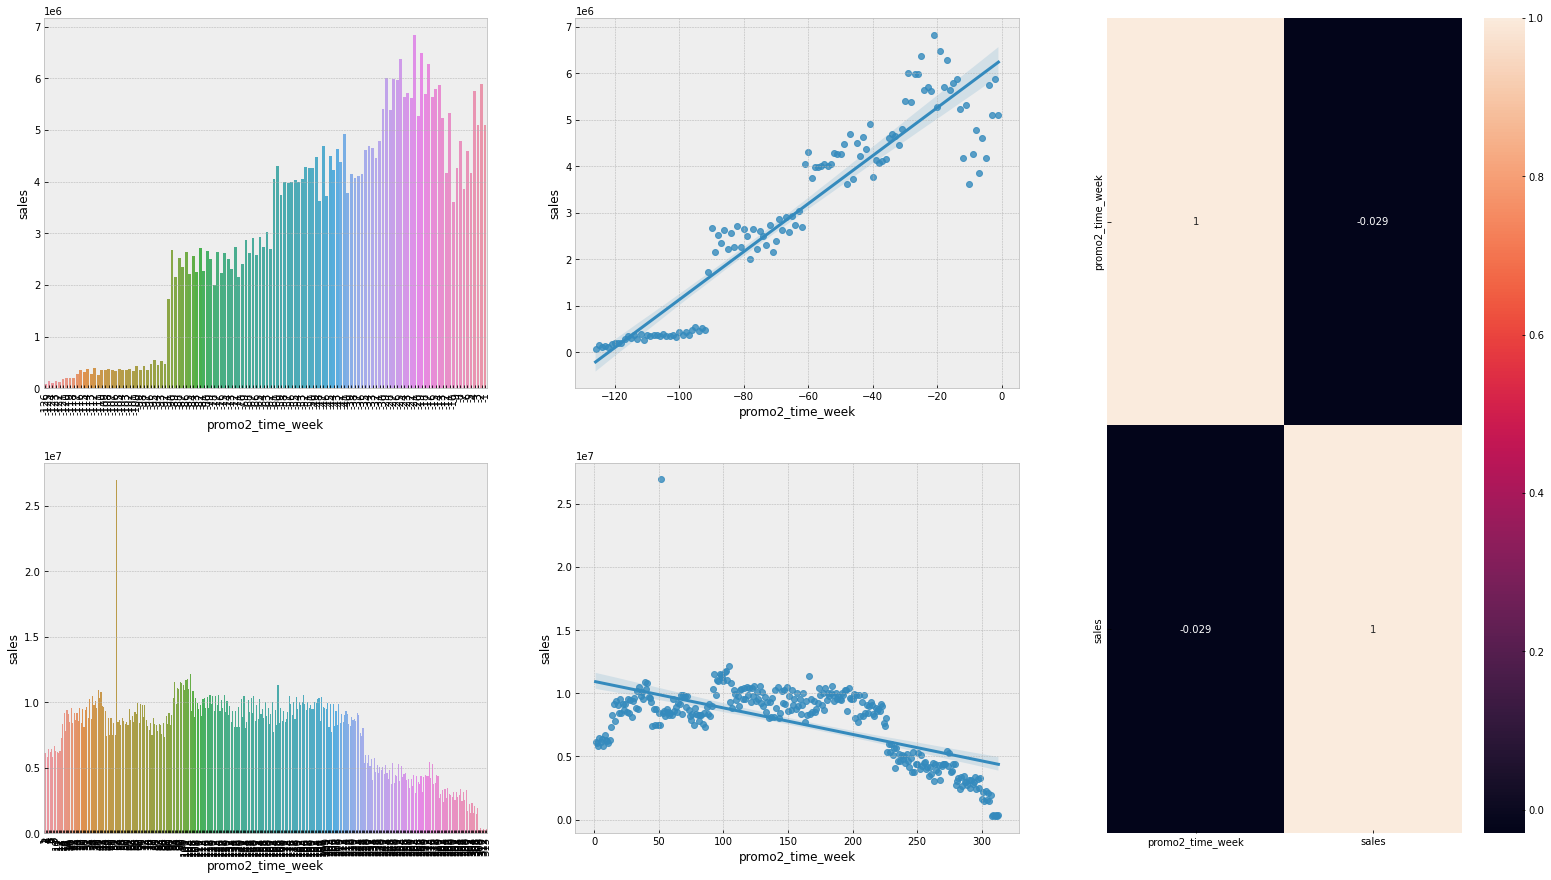

In [157]:
aux1 = pd.pivot_table(df4, values='sales', index='promo2_time_week', aggfunc='sum').reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux3 = aux1[aux1['promo2_time_week'] < 0] #regular promo (promo1)
sns.barplot(x='promo2_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo2_time_week', y='sales', data=aux3);

plt.subplot(grid[1,0])
aux2 = aux1[aux1['promo2_time_week'] > 0] #extended promo (promo2)
sns.barplot(x='promo2_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo2_time_week', y='sales', data=aux2);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Stores with longer promotions should sell more. </s>



### H6. Stores with more consecutive promotions should sell more.

**Rejected**. Stores that continue to promo2 sell less. And it can be relevant to the model.

In [158]:
pd.pivot_table(df4, values='sales', index=['promo', 'promo2'], aggfunc='sum').reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


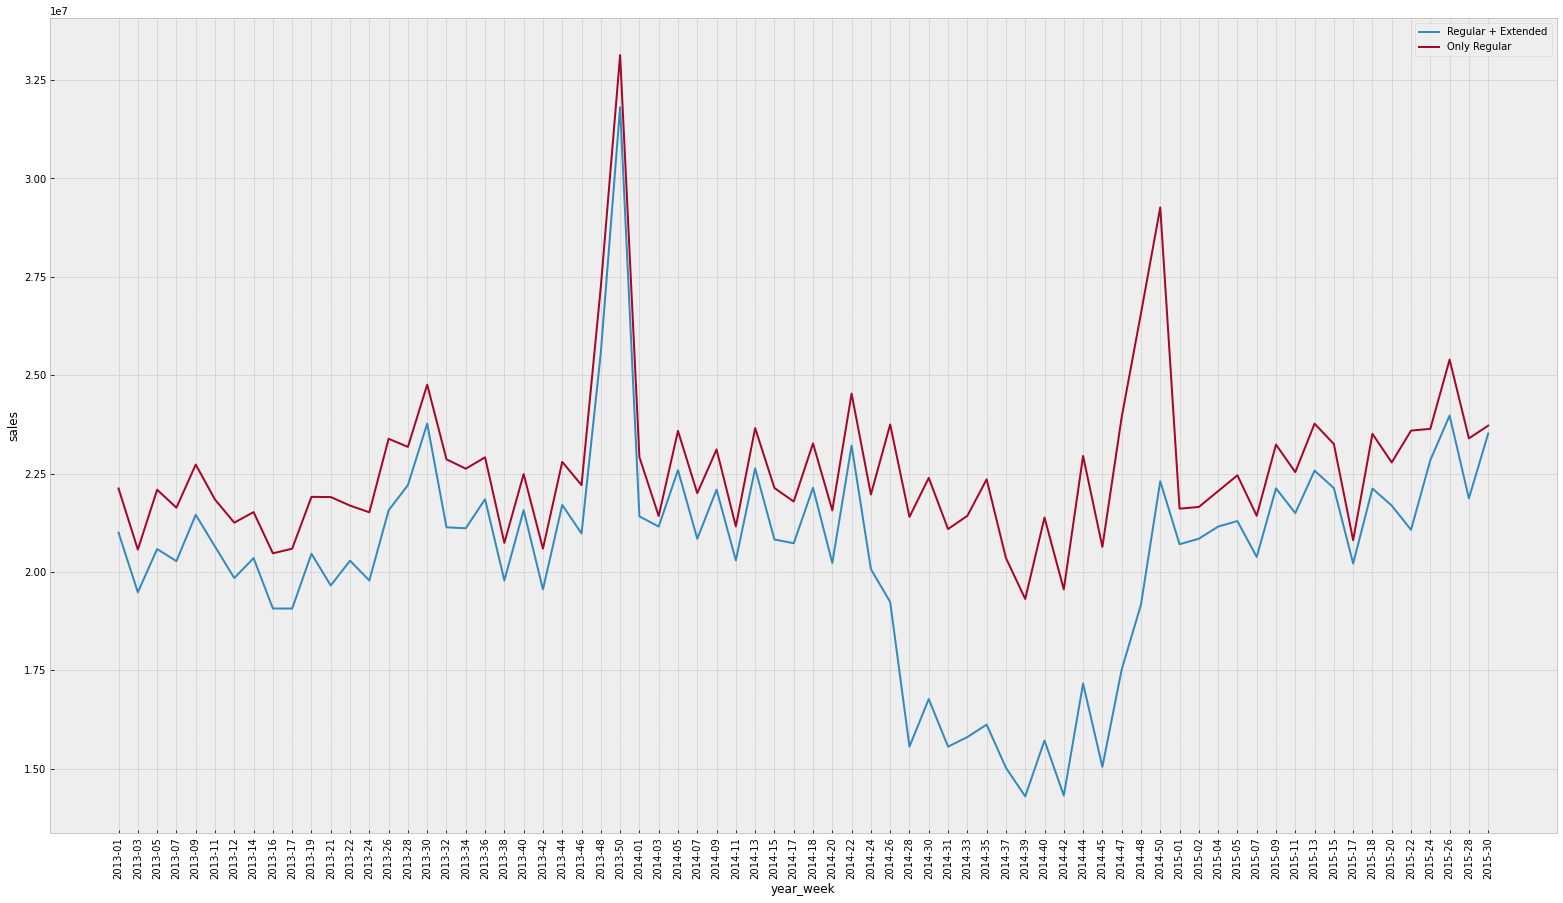

In [159]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)]
aux1 = pd.pivot_table(aux1, values='sales', index='year_week', aggfunc='sum').reset_index()
sns.lineplot(x=aux1['year_week'], y=aux1['sales']);

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)]
aux2 = pd.pivot_table(aux2, values='sales', index='year_week', aggfunc='sum').reset_index()
sns.lineplot(x=aux2['year_week'], y=aux2['sales']);

plt.xticks(rotation=90);
plt.legend(['Regular + Extended', 'Only Regular']);

### H7. Stores open at Christmas should sell more.

**Rejected**. Stores open at Christmas sell **less**. And it can be relevant to the model.

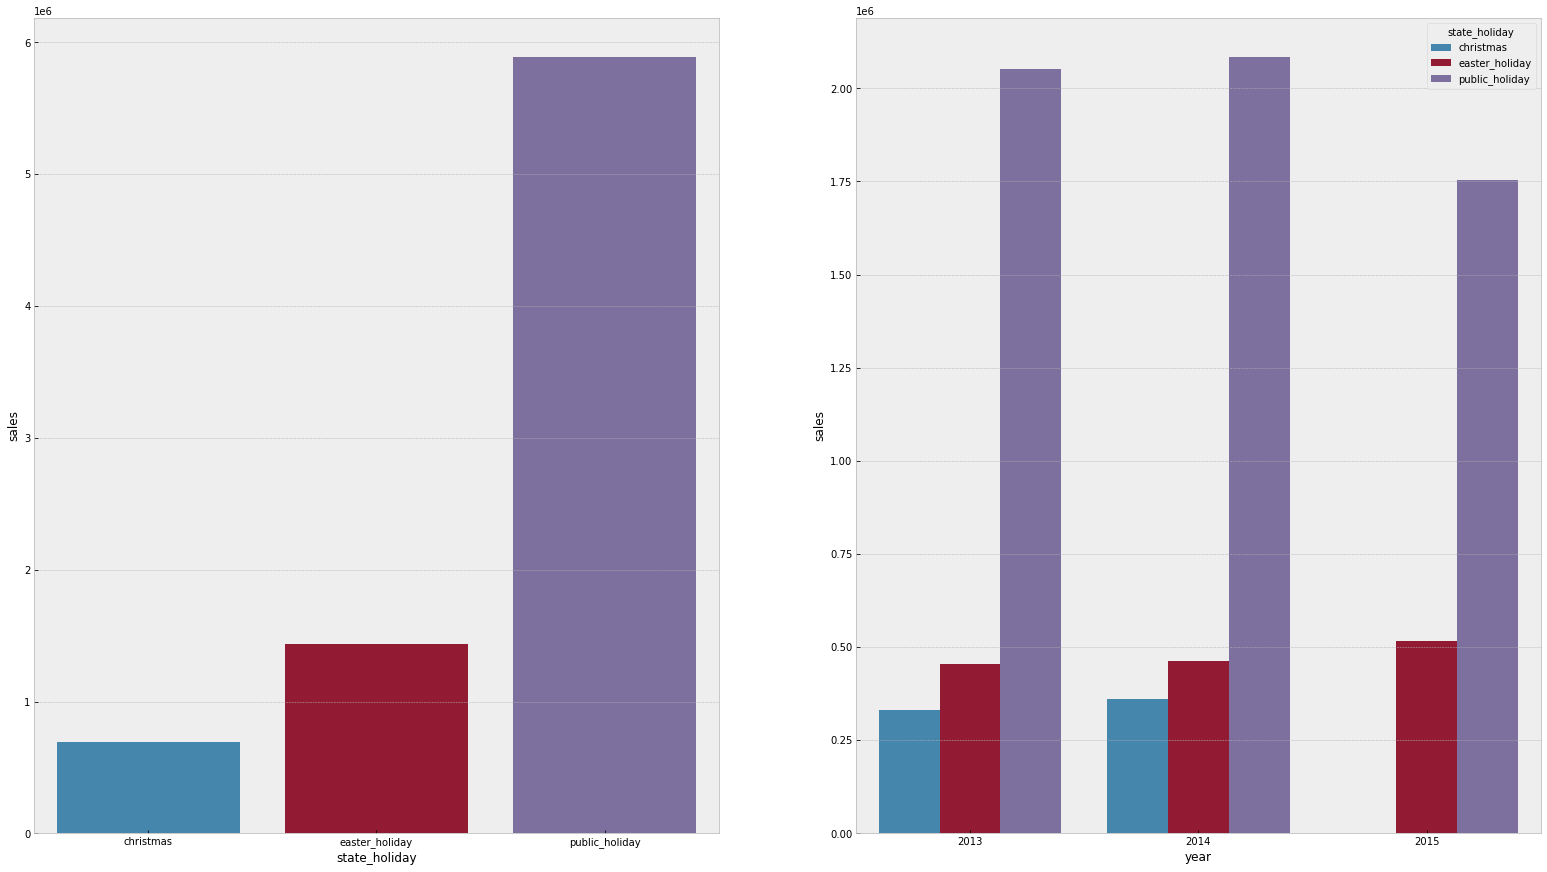

In [160]:
aux1 = pd.pivot_table(df4[df4['state_holiday'] != 'regular_day'], values='sales', index=['state_holiday', 'year'], aggfunc='sum').reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=aux1, ci=None, estimator=sum);

plt.subplot(1, 2, 2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux1);

### H8. Stores should sell more over the years.

**Rejected**. Stores sell **less** over the years. And it can be relevant to the model.

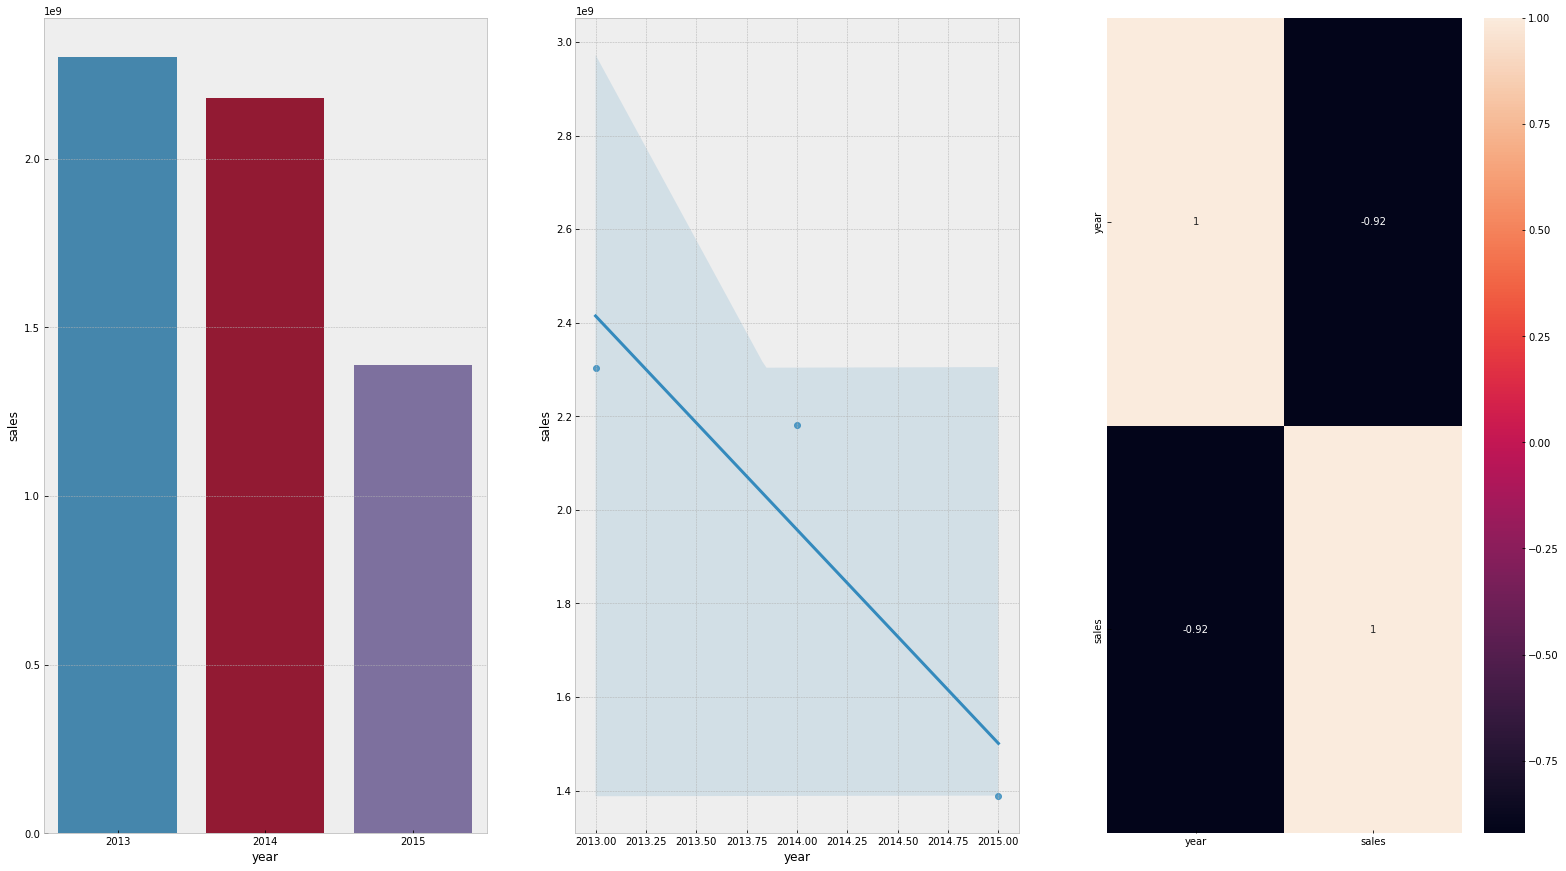

In [161]:
aux1 = pd.pivot_table(df4, values='sales', index='year', aggfunc='sum').reset_index()

plt.subplot(1, 3, 1);
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2);
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Stores should sell more in the second half of the year.

**Rejected**. Stores sell **less** in the second half of the year. And it can be relevant to the model.

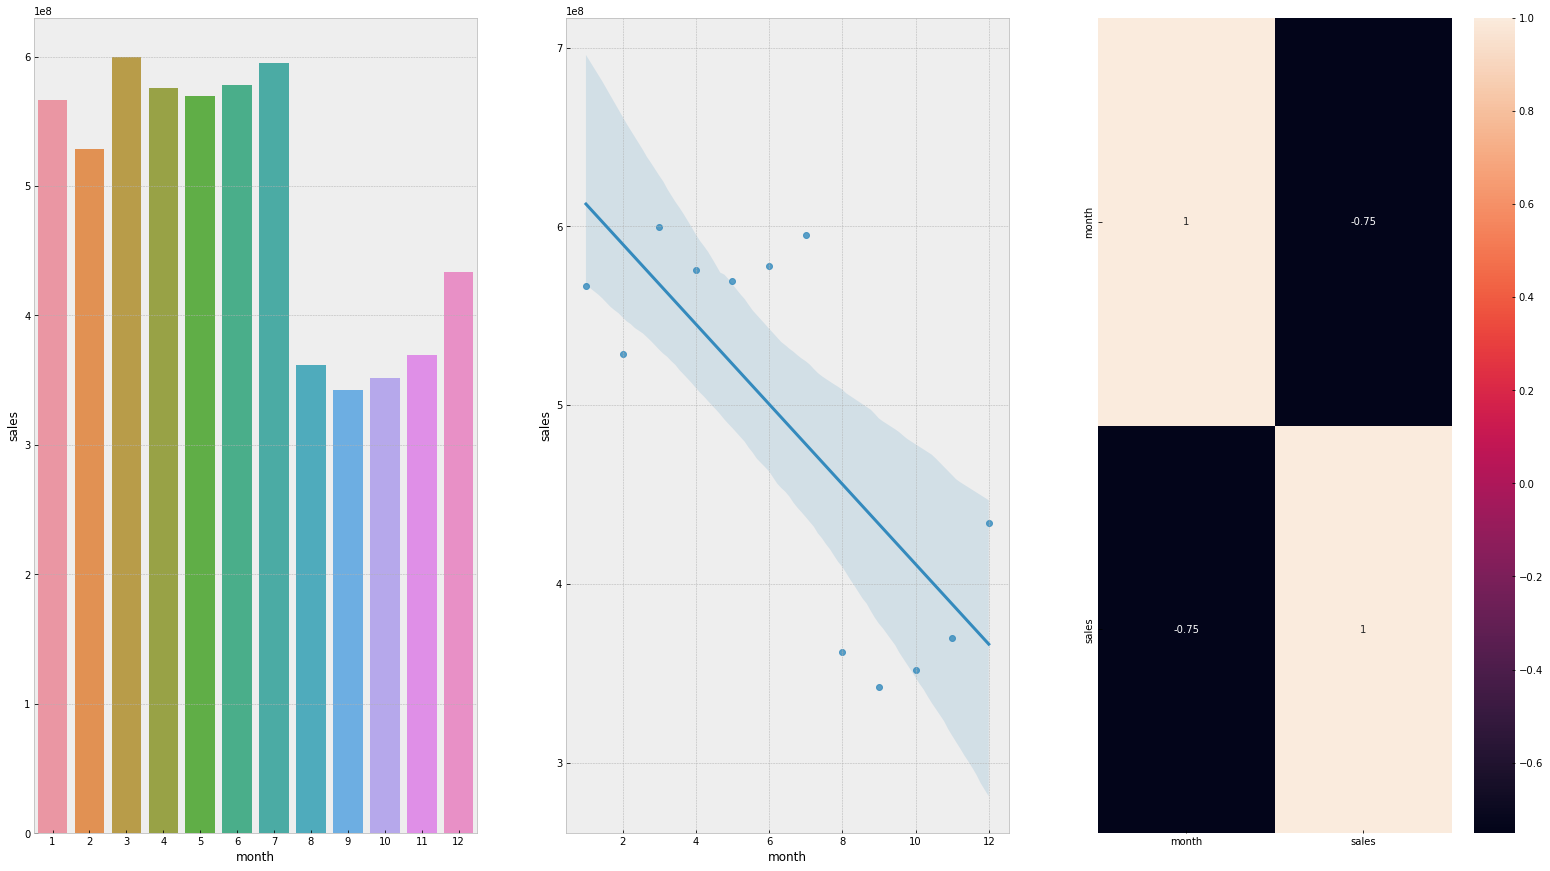

In [162]:
aux1 = pd.pivot_table(df4, values='sales', index='month', aggfunc='sum').reset_index()

plt.subplot(1, 3, 1);
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2);
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Stores should sell more after the 10th of each month.

**Accepted**. Stores sell **more** after the 10th of each month. And it can be relevant to the model.

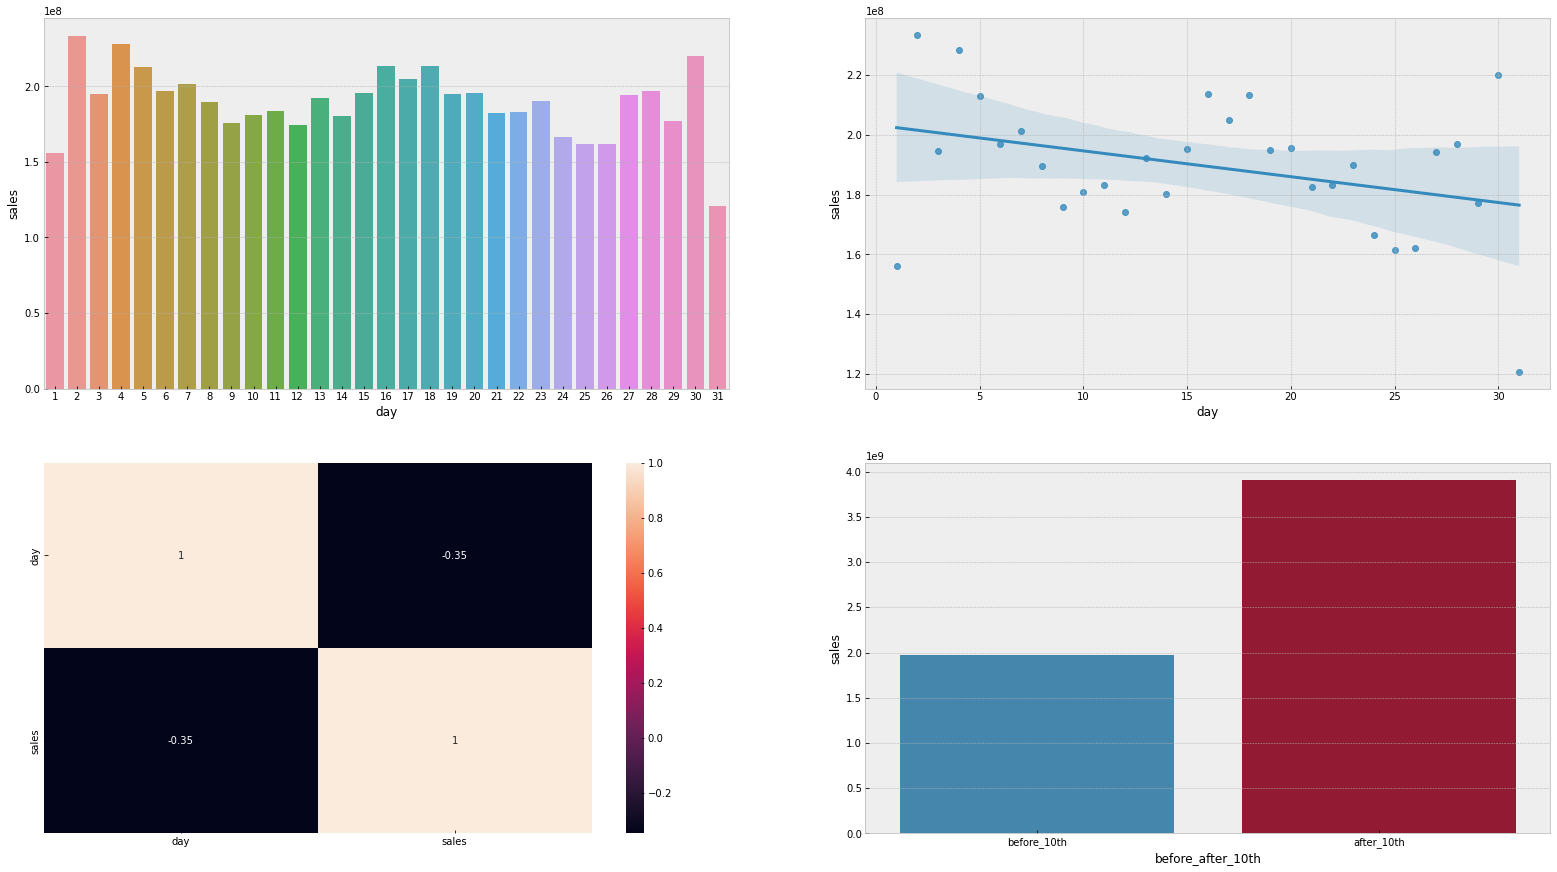

In [163]:
aux1 = pd.pivot_table(df4, values='sales', index='day', aggfunc='sum').reset_index()

plt.subplot(2, 2, 1);
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2);
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after_10th'] = aux1['day'].apply(lambda x: 'before_10th' if x <= 10 else 'after_10th')

plt.subplot(2, 2, 4);
sns.barplot(x='before_after_10th', y='sales', data=aux1, estimator=sum, ci=None);

### H11. Stores should sell less on weekend.

**Accepted**. Stores sell **less** on weekend. And it can be relevant to the model.

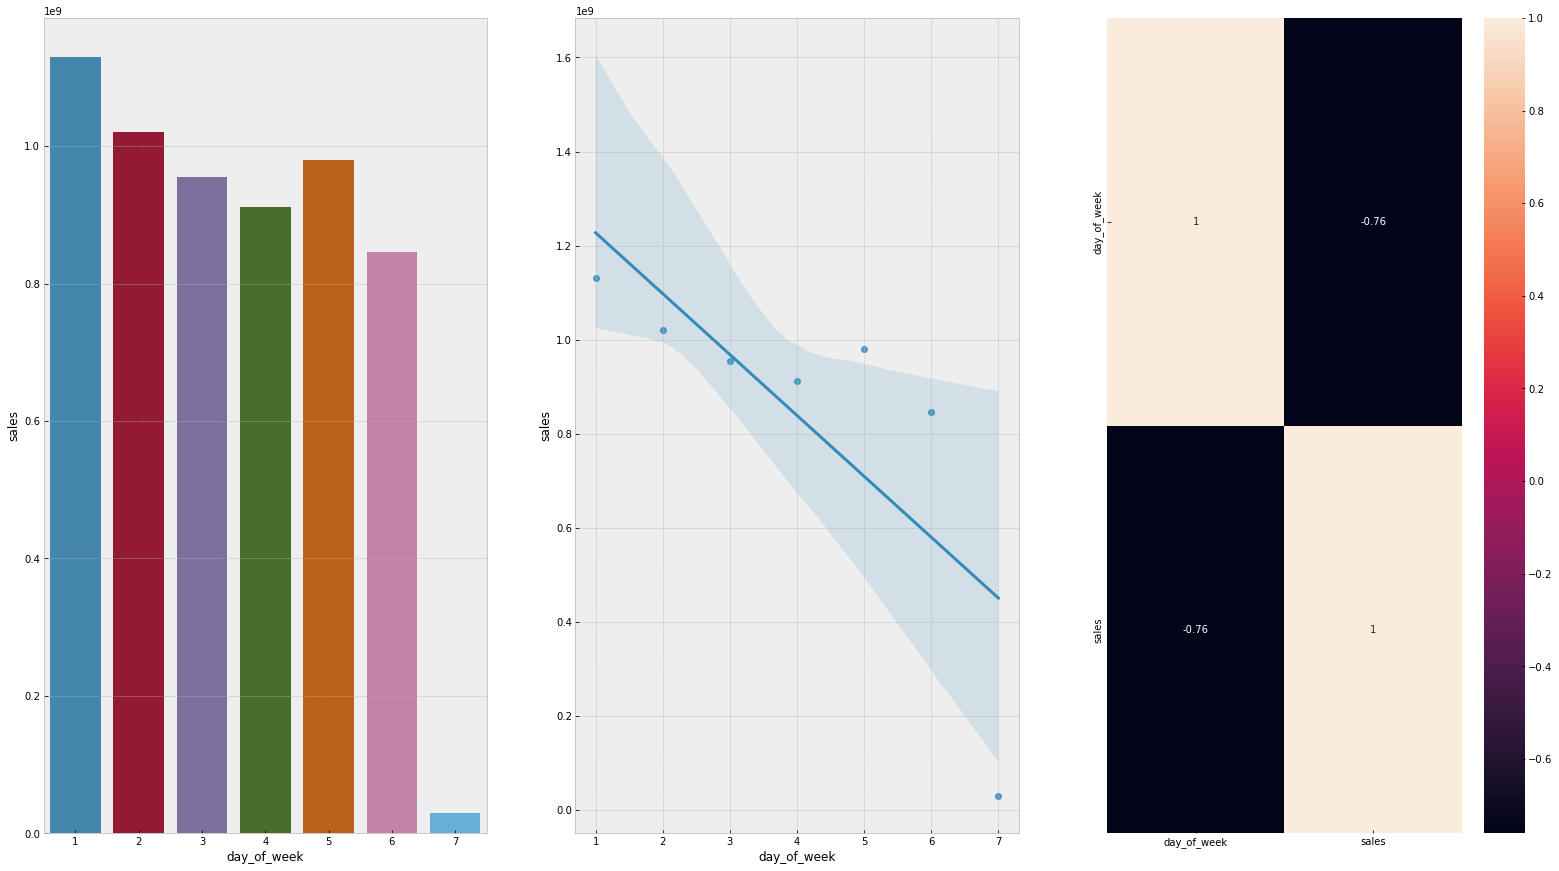

In [164]:
aux1 = pd.pivot_table(df4, values='sales', index='day_of_week', aggfunc='sum').reset_index()

plt.subplot(1, 3, 1);
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2);
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Stores should sell more during the School Holidays.

**Rejected**. Stores **only sell more** during the School Holidays in the month of **August**. And it can be relevant to the model.

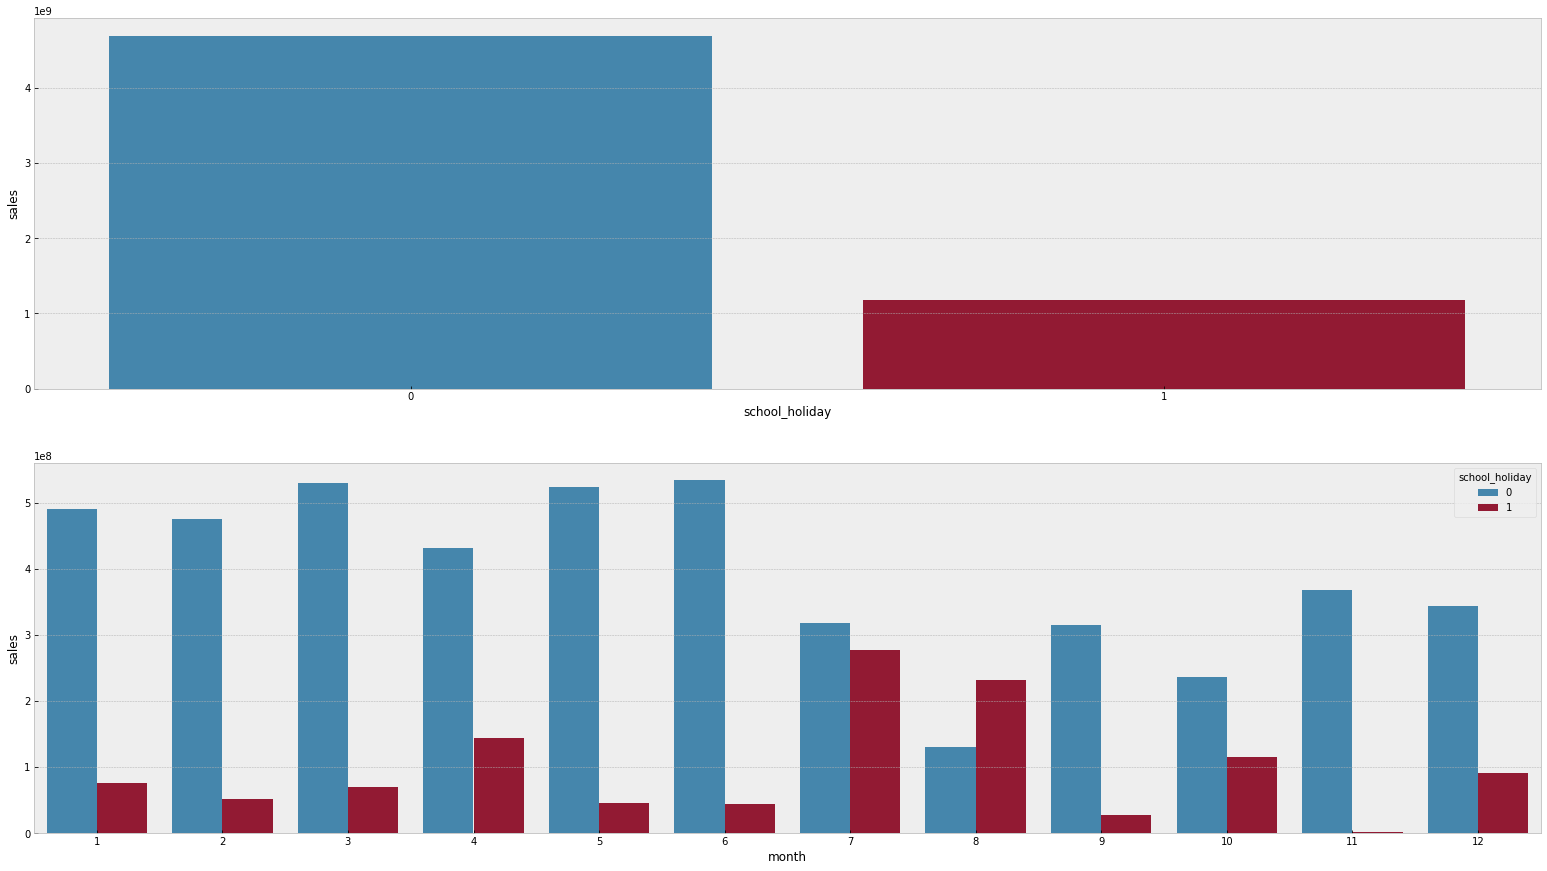

In [165]:
aux1 = pd.pivot_table(df4, values='sales', index=['month', 'school_holiday'], aggfunc='sum').reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1, estimator=sum, ci=None);

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1, estimator=sum, ci=None);

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

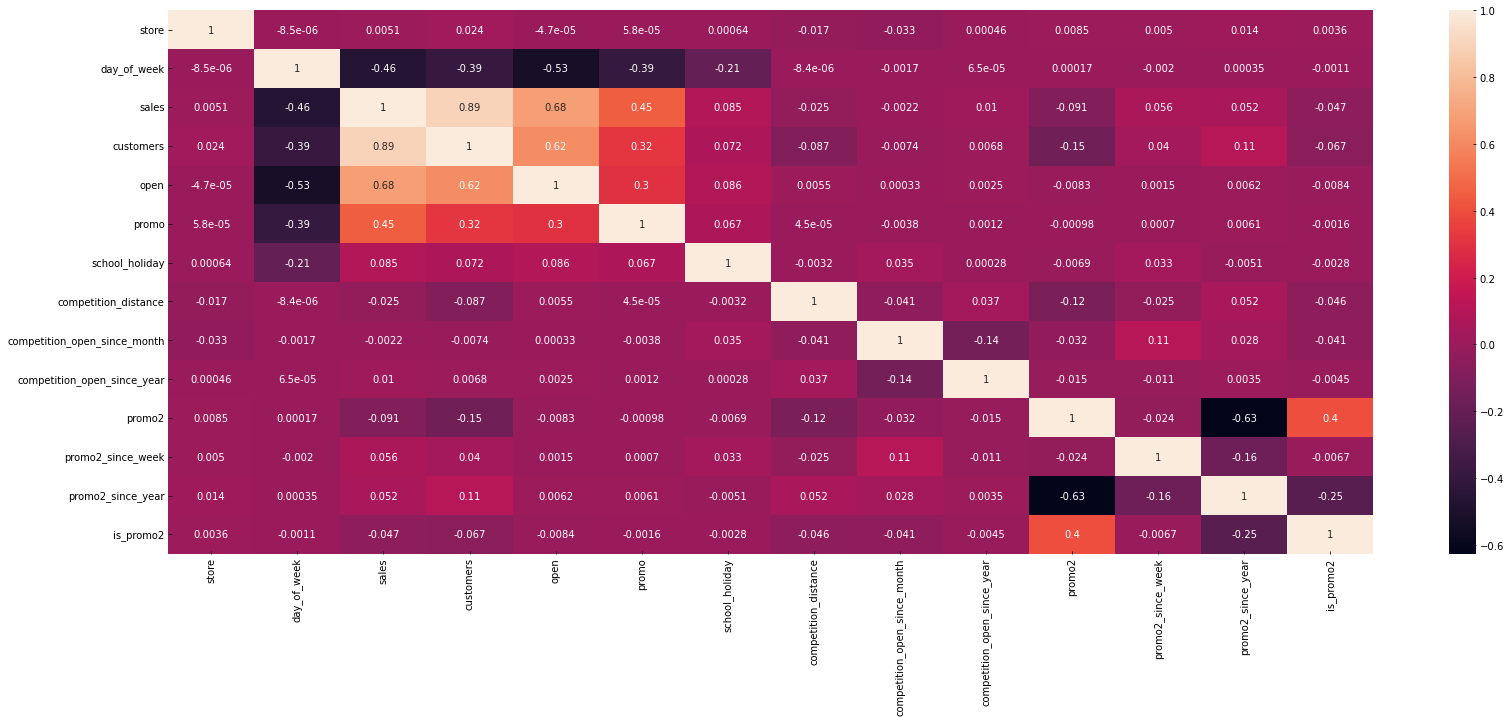

In [166]:
plt.rcParams['figure.figsize'] = [27, 10]
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

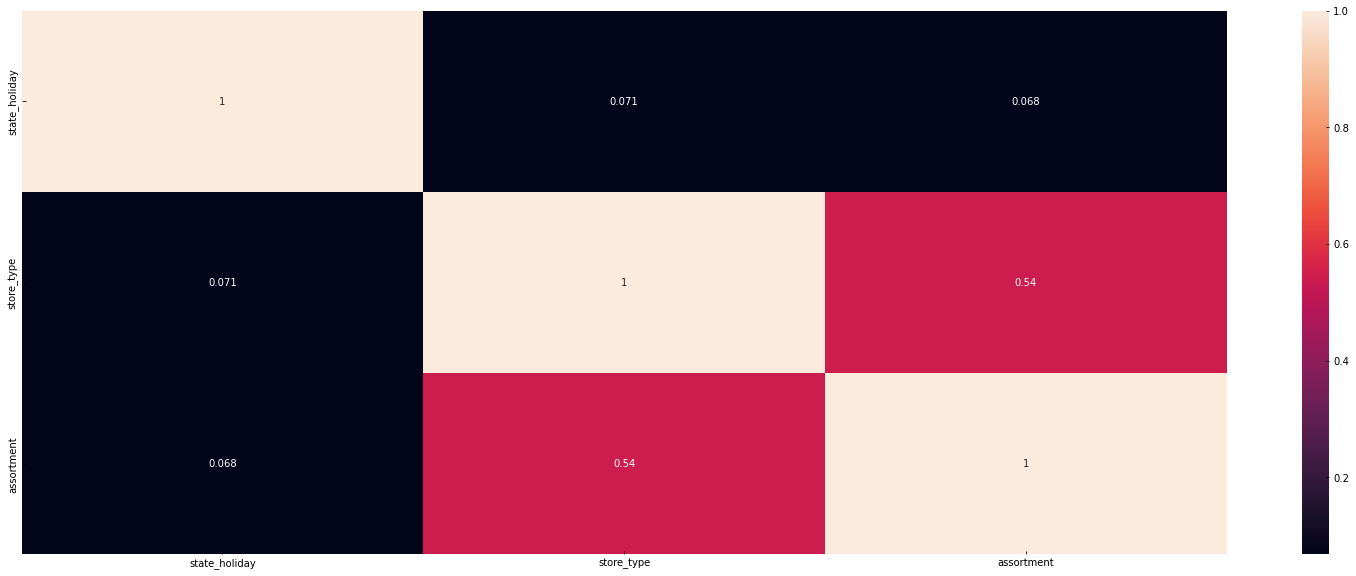

In [167]:
# only categorical data
a = df4.select_dtypes(include='object')

# calculate cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


# final dataframe
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9],})
d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5. DATA PREPARATION

In [168]:
df5 = df4.copy()

## 5.1. Standardizing

Thare no variables with Normal Distribution to standardize.

## 5.2. Rescaling

In [169]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo2_time_week
df5['promo2_time_week'] = mms.fit_transform(df5[['promo2_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Transformation

### 5.3.1. Encoding

In [170]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [171]:
# month
# day
# week_of_year
# day_of_week

### 5.3.2. Response Variable Transformation

In [172]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. Nature Transformation

### 5.3.3. Response Variable Transformation

In [173]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# 6. FEATURE SELECTION

In [174]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [175]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1) 

In [176]:
pd.pivot_table(df6, index='store', values='date', aggfunc='max').reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [177]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# training dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2. Boruta as feature selector

In [178]:
# training and test dataset for boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
Y_train_n = y_train.values.ravel()

# define Random Forest Regressor
rf = RandomForestRegressor(n_jobs=-1)

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

### 6.2.1 Best Features from Boruta

In [179]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected features
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### 6.3. Manual Feature Selection

In [180]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo2_time_week',
     'month_sin', 
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos',
     'day_of_week_sin',
     'day_of_week_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
# cols_selected_boruta.extend(feat_to_add)

In [181]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7. MACHINE LEARNING MODELLING

In [182]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Avarage Model

In [183]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = pd.pivot_table(aux1, index='store', values='sales', aggfunc='mean').reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Avarage Model', np.expm1(y_test), np.expm1(yhat_baseline)) 
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [184]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance

lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.367109,0.292879,2670.993696


## 7.3. Linear Regression Regularized Model - Lasso

In [185]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1892.318507,0.289171,2744.364675
